In [14]:
import osrs_GE

import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns

#from osrs_GE import elliptic_paraboloid_loss as eploss


import matplotlib.pyplot as plt

#### To-do
- Algorithmic way of determining return thresholds for classification?
    - Should be solely based off of some trailing vol ema

In [27]:
# dragonfire shield
item_id = 11284
freq = '6h'


item_name = osrs_GE.item_name_from_id(item_id)
df = osrs_GE.read_item_master_file(item_id,freq)
df = osrs_GE.compute_VWAP(df)
df.head()

File read successfully for Master Files/items/master_file_11284_6h.csv


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP
date,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06


In [28]:
df['simpRet_y'] = df['VWAP'].shift(-1)/df['VWAP'] - 1
df.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet_y
date,,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06,-0.006633
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06,-0.047092
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06,0.000898
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06,0.005086
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06,-0.003957


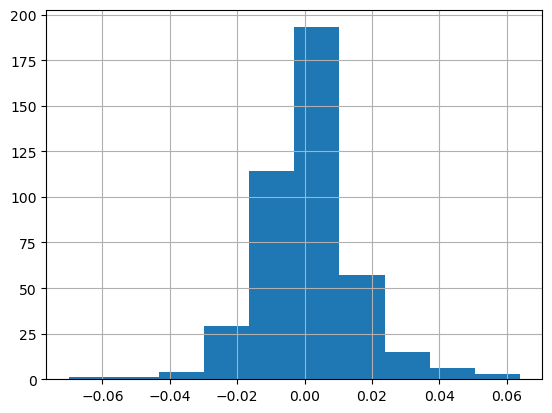

In [29]:
df['simpRet_y'].hist()
plt.show()

What features to include in forecasting price?
- order imbalance (+ lags)
- lagged returns
- TA indicators
  - RSI
  - MACD
  - SMA
  - LMA

In [30]:
### Creating features
#### parameters

RSI_window = 5
MACD_short = 3
MACD_long = 8

if freq == '6h':
    RSI_window = 10
    MACD_short = 4
    MACD_long = 16


##### RSI
df = osrs_GE.compute_RSI(df,window = RSI_window,col_name = 'VWAP')


##### Order Imbalance
df['OI'] = df['highPriceVolume'] -  df['lowPriceVolume']
df['OI*'] = df['OI']*((df['avgHighPrice'] > df['avgLowPrice'])*1 - (df['avgHighPrice'] < df['avgLowPrice']))
df['OI_ratio'] = df['OI']/(df['highPriceVolume'] + df['lowPriceVolume'])


##### Spread
df['Spread'] = df['avgHighPrice'] - df['avgLowPrice']
df['SpreadPct'] = df['Spread']/df['VWAP']


##### Cross Metric - interaction between the OI and the actively traded price spread
df['CM'] = df['SpreadPct']*df['OI']


##### MACD
df = osrs_GE.compute_MACD(df,st_n=MACD_short,lt_n=MACD_long, drop_ema_cols = False)
df['VWAP/ema'+str(MACD_short)] = df['VWAP']/df['VWAP_ema'+str(MACD_short)]
df['VWAP/ema'+str(MACD_long)] = df['VWAP']/df['VWAP_ema'+str(MACD_long)]
df['VWAP_nMACD_{0}_{1}'.format(MACD_short,MACD_long)] = df['VWAP_MACD_{0}_{1}'.format(MACD_short,MACD_long)]/df['VWAP']


df = df.drop(['timestamp','avgHighPrice','avgLowPrice','highPriceVolume',
            'lowPriceVolume','VWAP','VWAP_diff','OI*','Spread','VWAP_ema'+str(MACD_short),
            'VWAP_ema'+str(MACD_long),'VWAP_MACD_{0}_{1}'.format(MACD_short,MACD_long)],axis=1)

df = df.dropna()

df.head()

,simpRet_y,VWAP_RSI10,OI,OI_ratio,SpreadPct,CM,VWAP/ema4,VWAP/ema16,VWAP_nMACD_4_16
date,,,,,,,,,
2024-06-13 00:00:00,0.005685,28.204822,-3,-0.006160,0.010799,-0.032398,0.995829,0.989546,-0.006376
2024-06-13 06:00:00,-0.011487,28.792980,160,0.375587,0.006632,1.061199,1.000892,0.995900,-0.005009
2024-06-13 12:00:00,0.003358,47.990845,16,0.033755,0.016352,0.261632,0.993616,0.986705,-0.007049
2024-06-13 18:00:00,0.017145,51.113301,77,0.117199,0.016214,1.248510,0.998170,0.991427,-0.006814
2024-06-14 00:00:00,0.000640,62.258941,69,0.128015,0.018791,1.296571,1.009112,1.007246,-0.001835


In [31]:
df.shape

(413, 9)

In [33]:
# create train test split
train_idx = int(.8*df.index.shape[0])
train_dt = df.index[train_idx]
#train_dt = '2024-05-19'

df_tr = df[df.index < train_dt]
df_tr.shape

(330, 9)

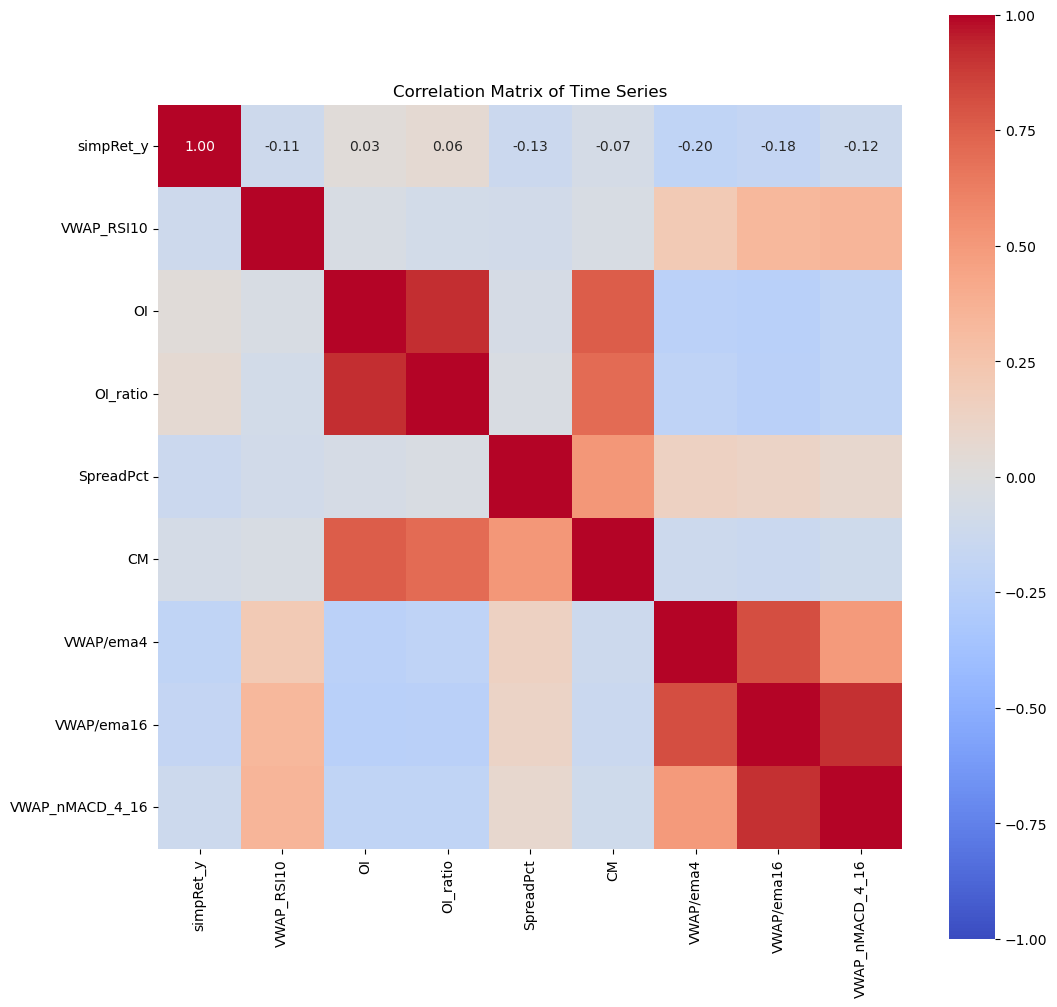

In [36]:
corr_matrix = df_tr.corr()

plt.figure(figsize=(12,12))

sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True,vmin=-1,vmax=1)

plt.title('Correlation Matrix of Time Series')
plt.show()

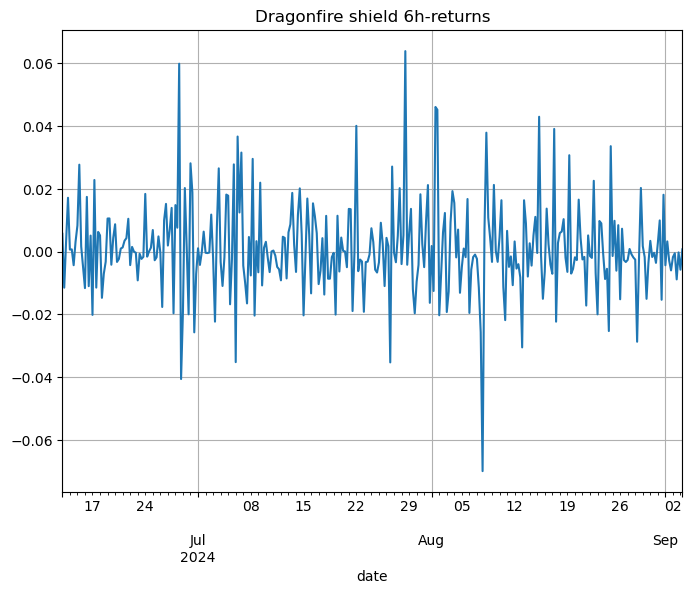

In [37]:
df_tr['simpRet_y'].plot(figsize=(8,6))
plt.title("{0} {1}-returns".format(item_name,freq))
plt.grid()
plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_tr['simpRet_y'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-16.339
p-value:0.0000
lags:1


# Return forecasting

## Feature selection for linear models

In [42]:
## Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold


X = df_tr.drop('simpRet_y',axis=1).values
y = df_tr['simpRet_y'].values

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
alpha = lasso_cv.best_params_['alpha']
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [43]:
names=df_tr.drop("simpRet_y", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['VWAP_RSI10' 'OI' 'OI_ratio' 'SpreadPct' 'CM' 'VWAP/ema4' 'VWAP/ema16'
 'VWAP_nMACD_4_16']


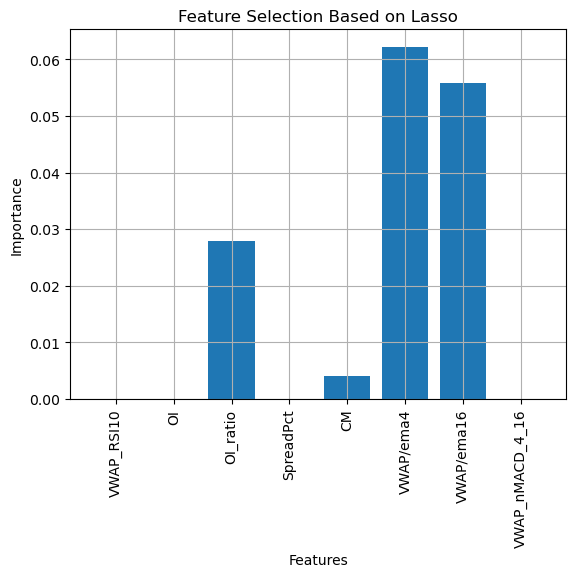

In [47]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X, y)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [49]:
# Subsetting the features that are relevant.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, 'simpRet_y')
print("Selected Columns: {}".format(feature_subset))

Selected Feature Columns: ['OI_ratio' 'CM' 'VWAP/ema4' 'VWAP/ema16']
Selected Columns: ['OI_ratio' 'CM' 'VWAP/ema4' 'VWAP/ema16' 'simpRet_y']


In [52]:
df_tr_new = df_tr[feature_subset]
df_tr_new.head()

,OI_ratio,CM,VWAP/ema4,VWAP/ema16,simpRet_y
date,,,,,
2024-06-13 00:00:00,-0.006160,-0.032398,0.995829,0.989546,0.005685
2024-06-13 06:00:00,0.375587,1.061199,1.000892,0.995900,-0.011487
2024-06-13 12:00:00,0.033755,0.261632,0.993616,0.986705,0.003358
2024-06-13 18:00:00,0.117199,1.248510,0.998170,0.991427,0.017145
2024-06-14 00:00:00,0.128015,1.296571,1.009112,1.007246,0.000640


In [56]:
df_tr_new.values[:5]

array([[-6.16016427e-03, -3.23975575e-02,  9.95828876e-01,
         9.89546327e-01,  5.68509329e-03],
       [ 3.75586854e-01,  1.06119924e+00,  1.00089232e+00,
         9.95899724e-01, -1.14868665e-02],
       [ 3.37552743e-02,  2.61632371e-01,  9.93615552e-01,
         9.86705037e-01,  3.35831198e-03],
       [ 1.17199391e-01,  1.24851010e+00,  9.98170177e-01,
         9.91427086e-01,  1.71448552e-02],
       [ 1.28014842e-01,  1.29657133e+00,  1.00911159e+00,
         1.00724629e+00,  6.39540985e-04]])

In [54]:
df_tr_new.values[:4]

array([[-0.00616016, -0.03239756,  0.99582888,  0.98954633,  0.00568509],
       [ 0.37558685,  1.06119924,  1.00089232,  0.99589972, -0.01148687],
       [ 0.03375527,  0.26163237,  0.99361555,  0.98670504,  0.00335831],
       [ 0.11719939,  1.2485101 ,  0.99817018,  0.99142709,  0.01714486]])

In [55]:
df_tr_new.values[4]

array([1.28014842e-01, 1.29657133e+00, 1.00911159e+00, 1.00724629e+00,
       6.39540985e-04])

In [62]:
X_tr[[3]].shape

(1, 4)

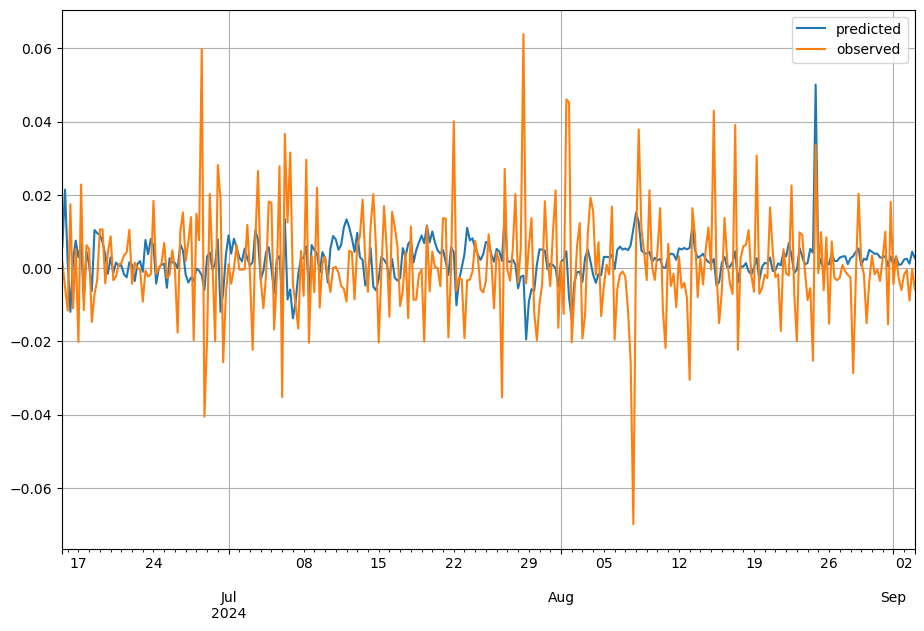

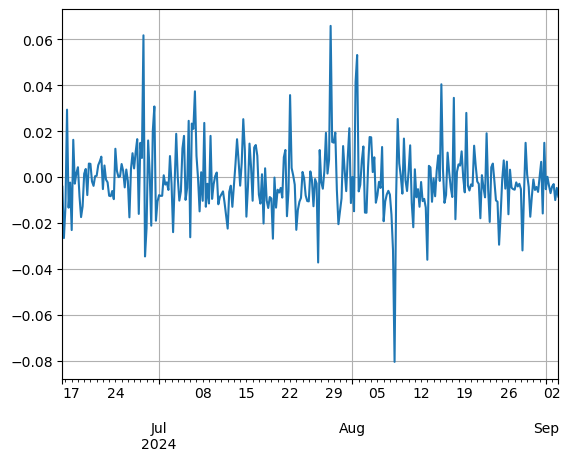

In [77]:
start_point = 10
X_tr = df_tr_new.drop('simpRet_y',axis=1).values
y_tr = df_tr_new['simpRet_y'].values
model = LinearRegression()

feature_shape = X_tr.shape[1]

errors = []
preds = []
obs = []
index = []

for i in range(start_point,X_tr.shape[0]-1):
    # train on data up to i
    _X = X_tr[:i]
    _y = y_tr[:i]
    model_fit = model.fit(_X,_y)
    
    # predict i+1
    x_predict = X_tr[[i]]
    y_hat = model_fit.predict(x_predict)[0]
    y_obs = y_tr[i]
    
    # record errors
    errors.append(y_obs - y_hat)
    preds.append(y_hat)
    obs.append(y_obs)
    
    index.append(df_tr_new.index[i])
    

df_err = pd.DataFrame({'errors': errors,
                       'predicted': preds,
                       'observed': obs}, index=index)

df_err[['predicted','observed']].plot(figsize=(11,7))
plt.grid()
plt.show()


df_err['errors'].plot()
plt.grid()
plt.show()